In [1]:
import scanpy
import anndata
from matplotlib import pyplot
import numpy
import scvelo

/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
#%% Read input file

scanpy.settings.set_figure_params(dpi=100, facecolor="white")

seq_file_path = "RNA Sequencing Data/220701Pool1-Pool3.h5ad"
adata = scanpy.read_h5ad(seq_file_path)

In [3]:
#%% Analyze file

print(adata)
print(adata.obs.columns)
print("Identities: ", numpy.sort(adata.obs["orig.ident"].unique()))
print("Days: ", numpy.sort(adata.obs["Day"].unique()))
# Value counts
print(adata.obs["Day"].value_counts())

AnnData object with n_obs × n_vars = 13315 × 20959
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'Day', 'MEF.identity', 'Pluripotency', 'Proliferation', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'Senescence', 'Neural.identity', 'Trophoblast.identity', 'X.reactivation', 'XEN', 'Trophoblast.progenitors', 'Spiral.Artery.Trophpblast.Giant.Cells', 'Spongiotrophoblasts', 'Oligodendrocyte.precursor.cells..OPC.', 'Astrocytes', 'Cortical.Neurons', 'RadialGlia.Id3', 'RadialGlia.Gdf10', 'RadialGlia.Neurog2', 'Long.term.MEFs', 'Embryonic.mesenchyme', 'Cxcl12.co.expressed', 'Ifitm1.co.expressed', 'Matn4.co.expressed', '2c', 'keratinization', 'skin.development', 'muscle.structure.development', 'cartilage.development', 'blood.vessel.development', 'skeletal.system.development', 'nervous.system.development', 'neuron.development', 'stem.cell.population.maintenance'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.varia

In [4]:
# Check how orig.ident relates to day
for identity in numpy.sort(adata.obs['orig.ident'].unique()):
    print(f"Identity: {identity}")
    day_data = adata.obs.loc[adata.obs['orig.ident']==identity, 'Day']
    print("Value counts:")
    print(day_data.value_counts())
    print()

Identity: 0
Value counts:
Day
0    1586
Name: count, dtype: int64

Identity: 1
Value counts:
Day
1    910
Name: count, dtype: int64

Identity: 2
Value counts:
Day
2    862
Name: count, dtype: int64

Identity: 3
Value counts:
Day
3    1072
Name: count, dtype: int64

Identity: 4
Value counts:
Day
4    1123
Name: count, dtype: int64

Identity: 5
Value counts:
Day
5    1279
Name: count, dtype: int64

Identity: 6
Value counts:
Day
6    1331
Name: count, dtype: int64

Identity: 7
Value counts:
Day
7    1331
Name: count, dtype: int64

Identity: 8
Value counts:
Day
8    916
Name: count, dtype: int64

Identity: 9
Value counts:
Day
9    717
Name: count, dtype: int64

Identity: 10
Value counts:
Day
10    471
Name: count, dtype: int64

Identity: 11
Value counts:
Day
11    320
Name: count, dtype: int64

Identity: 12
Value counts:
Day
11    1397
Name: count, dtype: int64



In [3]:
#%% Map identities to day and group

print("Identities (Days):")
print(adata.obs["Day"].value_counts())

day_map={
    0: None,
    1: 2,
    2: 2,
    3: 4,
    4: 4,
    5: 6,
    6: 6,
    7: 9,
    8: 9,
    9: 12,
    10: 12,
    11: None,
}

group_map={
    0: "MEFs",
    1: "control",
    2: "Hic2",
    3: "control",
    4: "Hic2",
    5: "control",
    6: "Hic2",
    7: "control",
    8: "Hic2",
    9: "control",
    10: "Hic2",
    11: "ESCs",
}

adata.obs["exp_day"] = adata.obs["Day"].map(day_map)
adata.obs["group"] = adata.obs["Day"].map(group_map)

experiment_groups = {"control", "Hic2"}
reference_groups = {"MEFs", "ESCs"}

print("Experiment groups:")
print(f"{adata.obs[["exp_day", "group"]].value_counts(sort=False)}\n")

print("Reference groups:")
print(f"{adata.obs.query("group in @reference_groups")["group"].value_counts(sort=False)}\n")

Identities (Days):
Day
11    1717
0     1586
6     1331
7     1331
5     1279
4     1123
3     1072
8      916
1      910
2      862
9      717
10     471
Name: count, dtype: int64
Experiment groups:
exp_day  group  
2.0      Hic2        862
         control     910
4.0      Hic2       1123
         control    1072
6.0      Hic2       1331
         control    1279
9.0      Hic2        916
         control    1331
12.0     Hic2        471
         control     717
Name: count, dtype: int64

Reference groups:
group
ESCs    1717
MEFs    1586
Name: count, dtype: int64



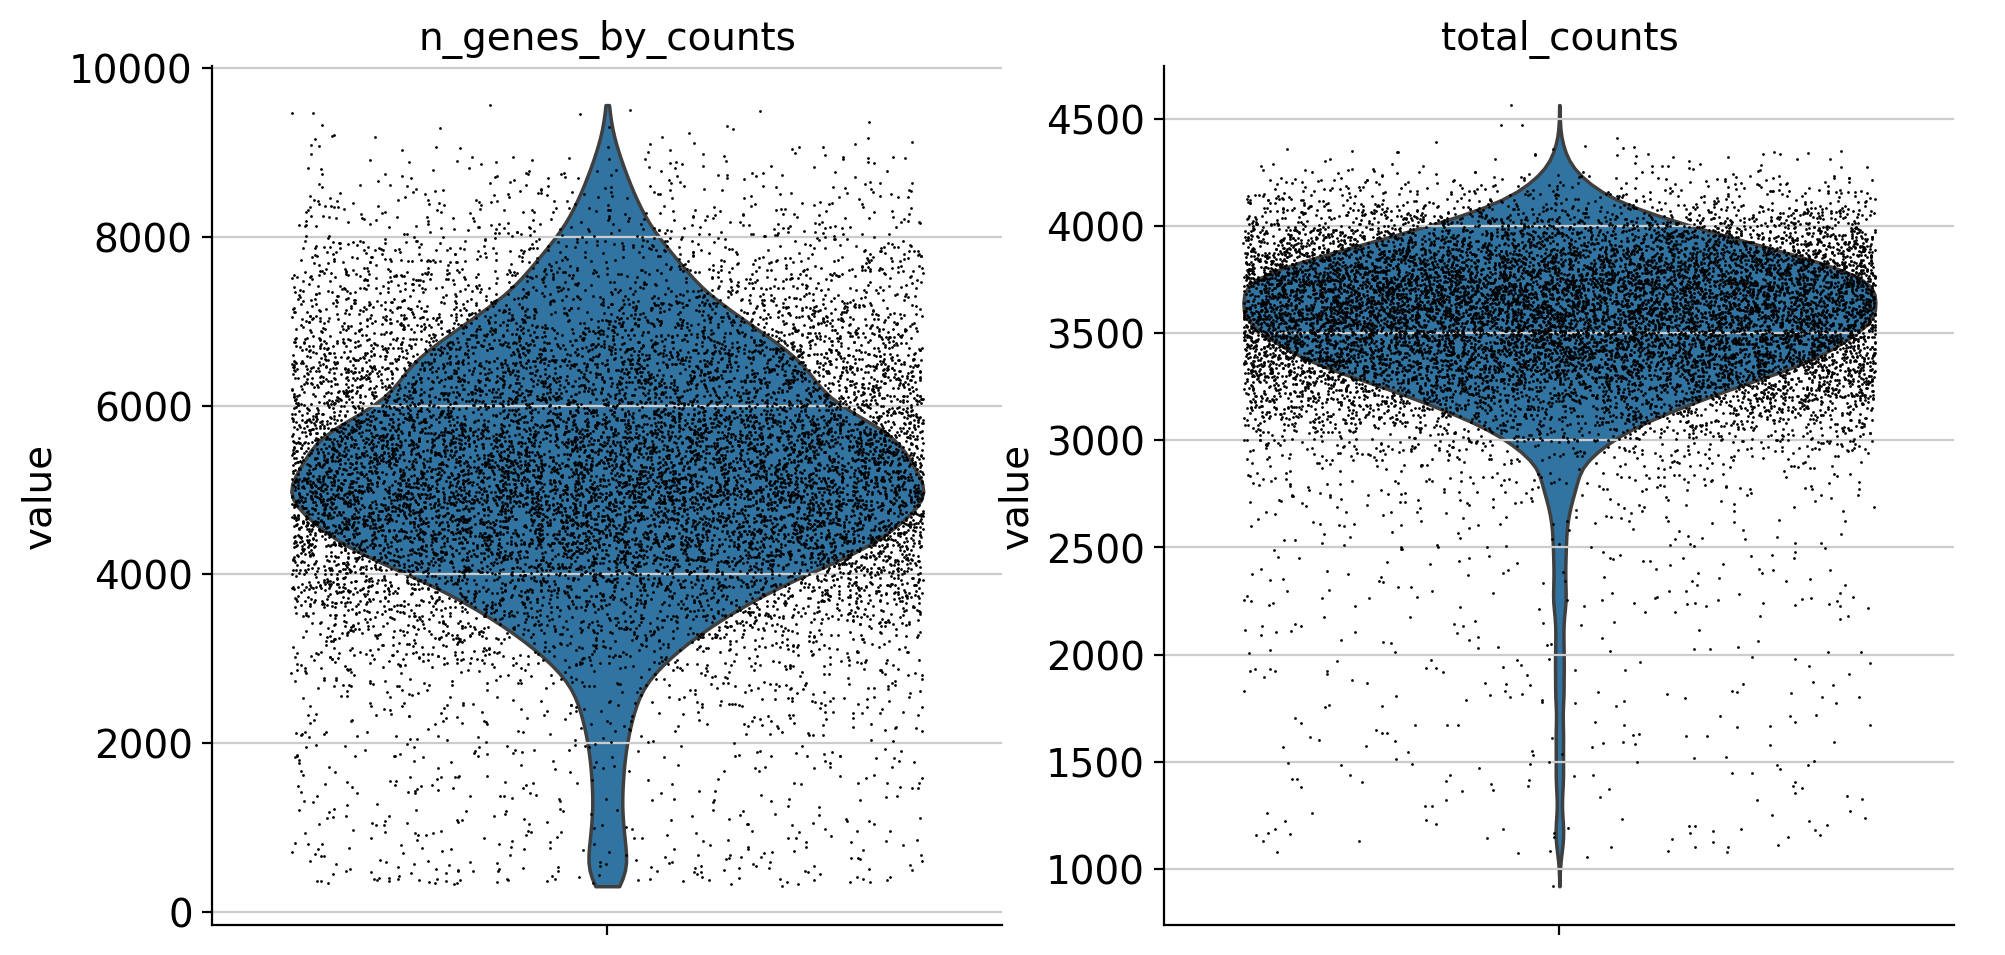

/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/plotting/_anndata.py:397: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if key in adata.obs_keys():


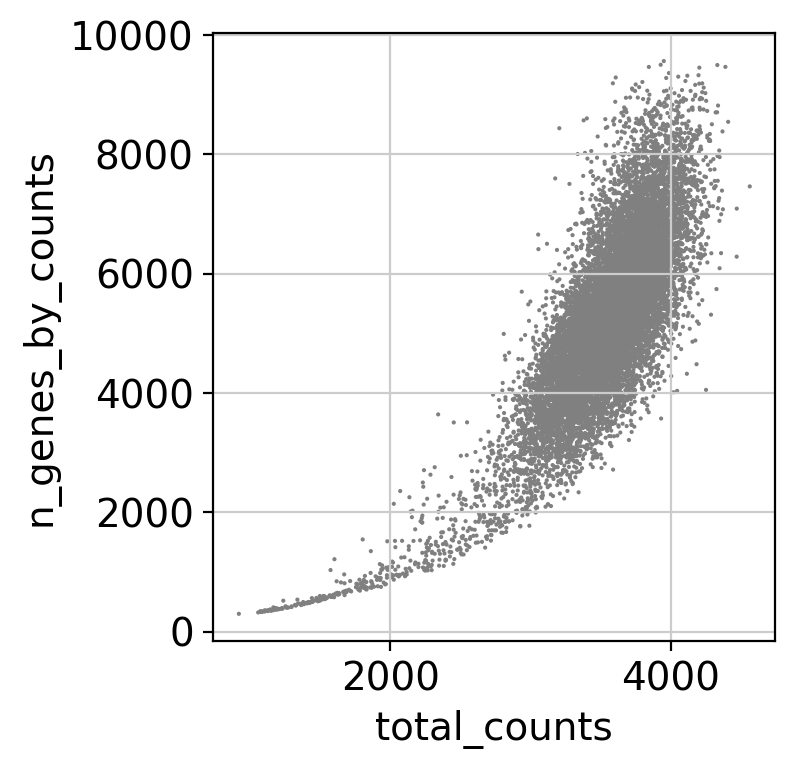

In [6]:
#%% Quality control

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p)]")

scanpy.pp.calculate_qc_metrics(
    adata, qc_vars=["ribo", "hb"], inplace=True, log1p=True
)

scanpy.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

scanpy.pl.scatter(adata, "total_counts", "n_genes_by_counts")

Min: 0.0
Max: 8.60092094002665
Mean: 0.16834041326855712


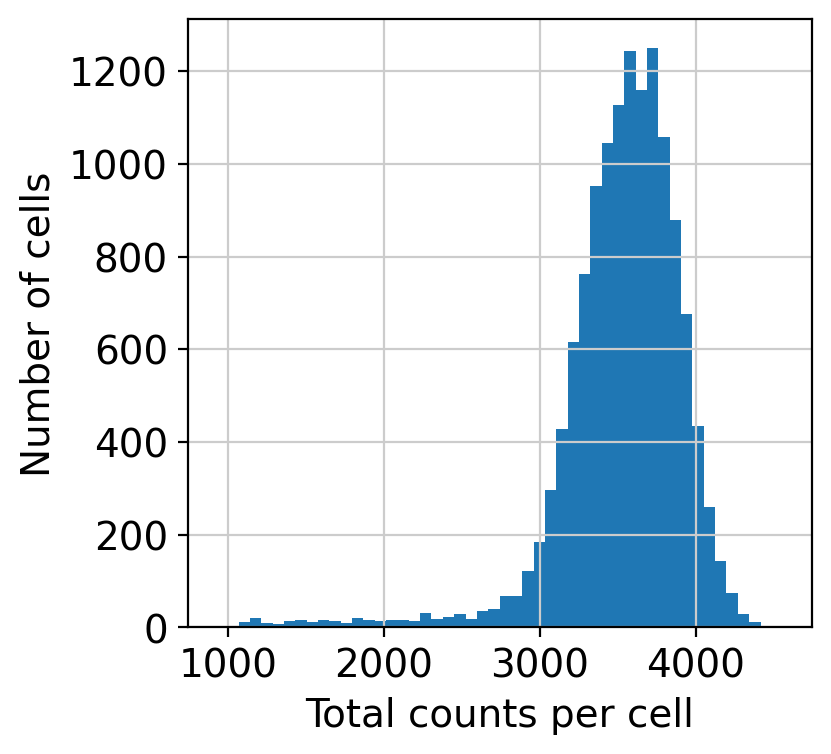

In [7]:
#%% Normalization if necessary

print("Min:", numpy.min(adata.X))
print("Max:", numpy.max(adata.X))
print("Mean:", numpy.mean(adata.X))

adata.obs['total_counts'] = adata.X.sum(axis=1)
adata.obs['total_counts'].describe()

pyplot.hist(adata.obs['total_counts'], bins=50)
pyplot.xlabel('Total counts per cell')
pyplot.ylabel('Number of cells')
pyplot.show()

# Data is already log-transformed

/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


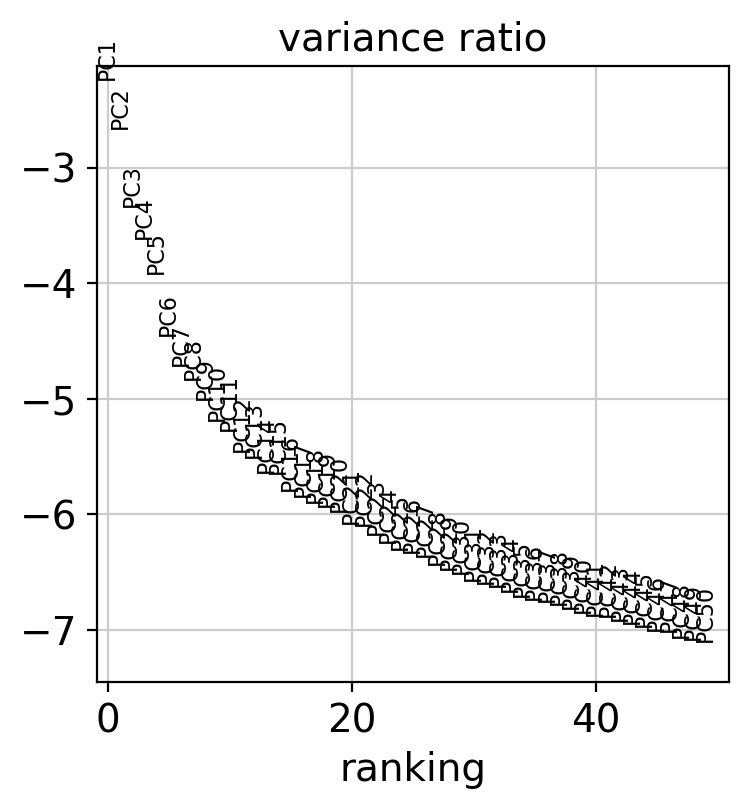

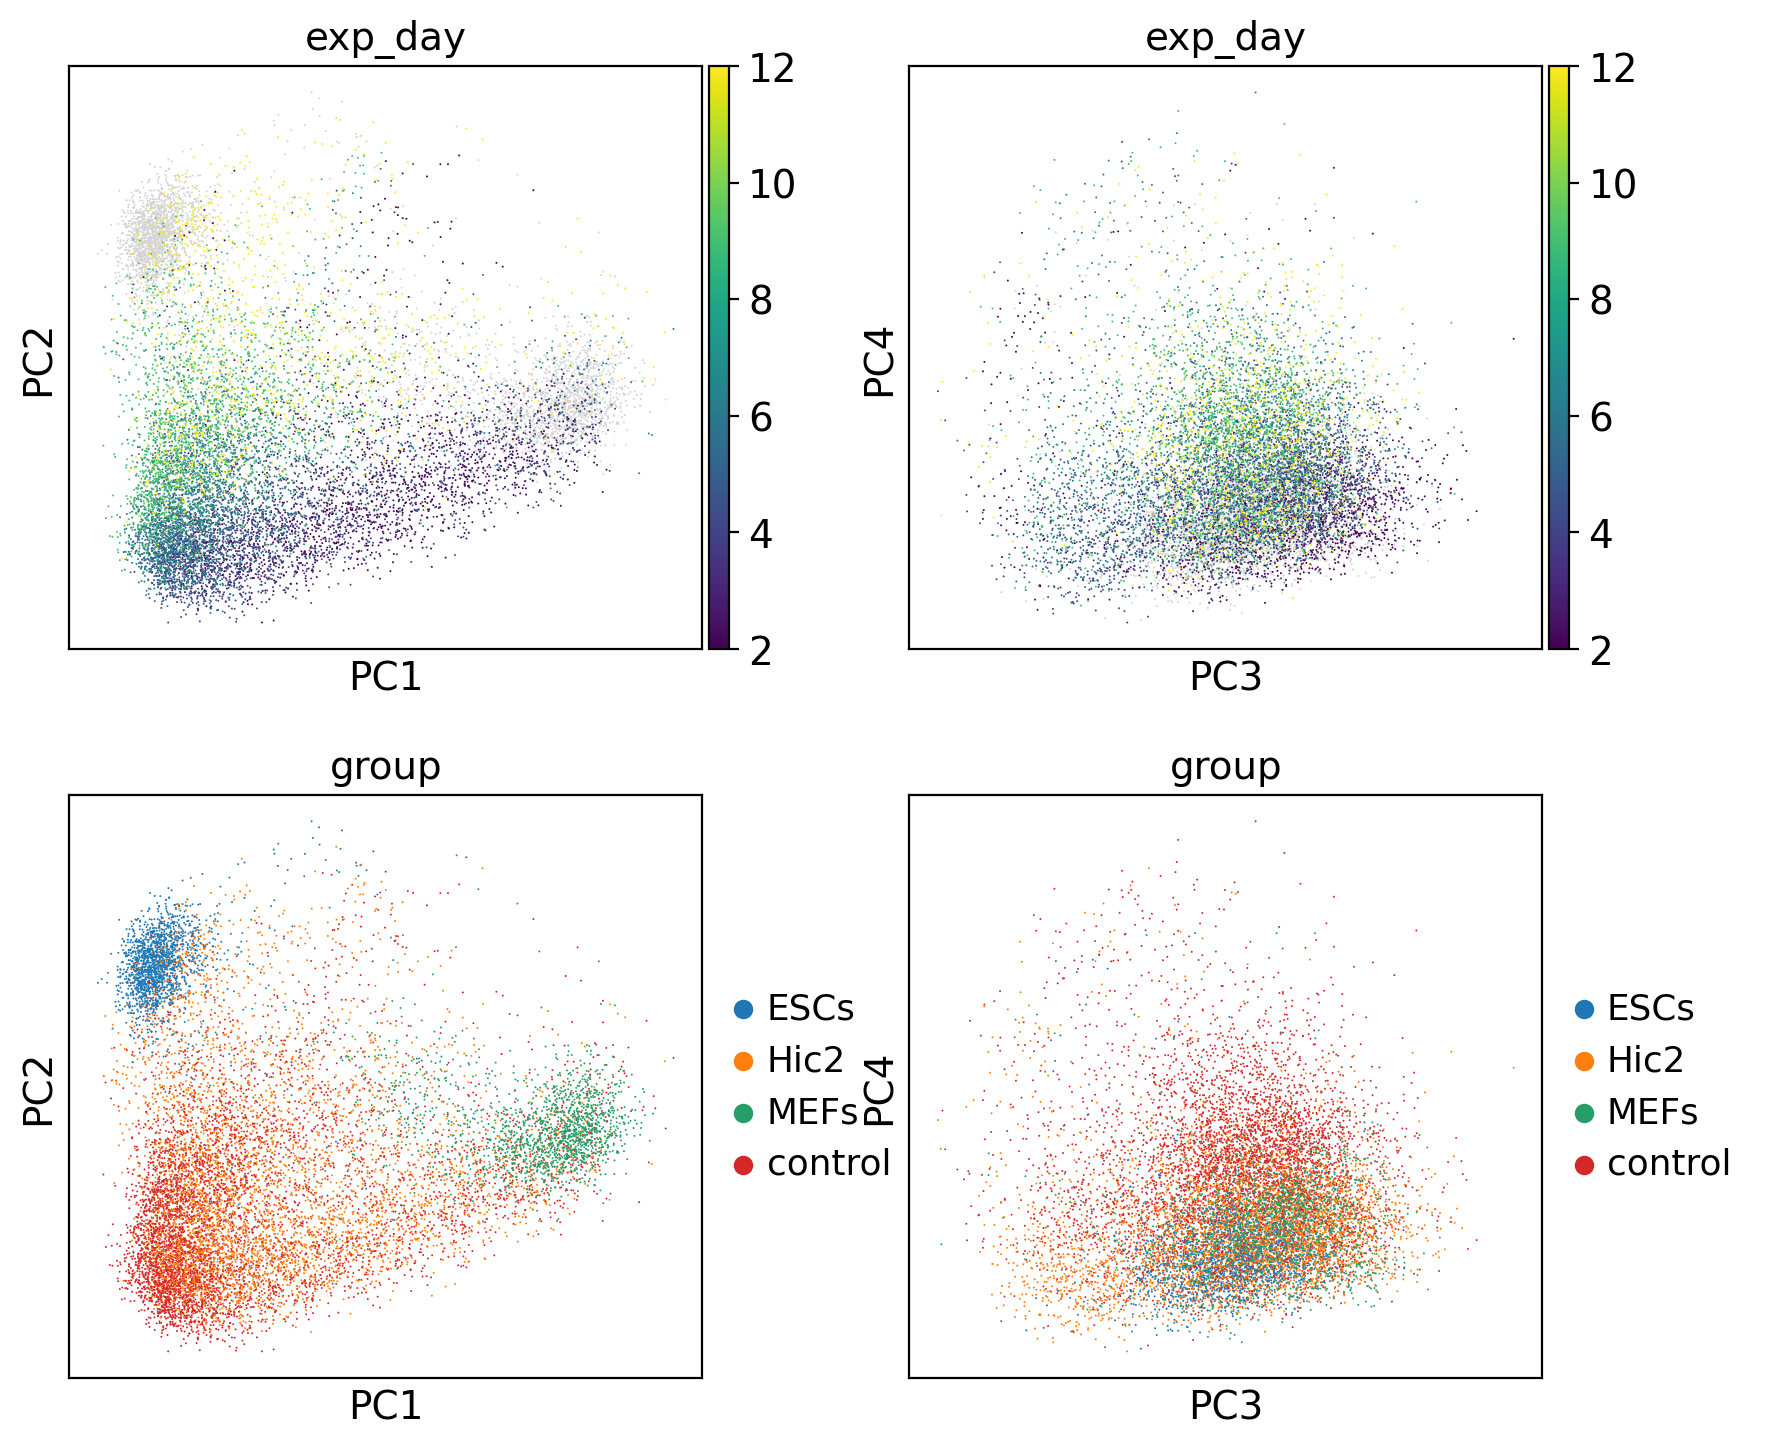

In [8]:
#%% Clustering

scanpy.tl.pca(adata)
scanpy.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
scanpy.pl.pca(
    adata,
    color=["exp_day", "exp_day", "group", "group"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [6]:
#%% Get important genes

model_genes = ["Krtdap", "Hic2", "Nanog", "Klf4"]

model_data = adata[:, model_genes].copy()

krt_data = adata[:, "Krtdap"]
hic2_data = adata[:, "Hic2"]
nanog_data = adata[:, "Nanog"]
klf4_data = adata[:, "Klf4"]

print(krt_data)


View of AnnData object with n_obs × n_vars = 13315 × 1
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'Day', 'MEF.identity', 'Pluripotency', 'Proliferation', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'Senescence', 'Neural.identity', 'Trophoblast.identity', 'X.reactivation', 'XEN', 'Trophoblast.progenitors', 'Spiral.Artery.Trophpblast.Giant.Cells', 'Spongiotrophoblasts', 'Oligodendrocyte.precursor.cells..OPC.', 'Astrocytes', 'Cortical.Neurons', 'RadialGlia.Id3', 'RadialGlia.Gdf10', 'RadialGlia.Neurog2', 'Long.term.MEFs', 'Embryonic.mesenchyme', 'Cxcl12.co.expressed', 'Ifitm1.co.expressed', 'Matn4.co.expressed', '2c', 'keratinization', 'skin.development', 'muscle.structure.development', 'cartilage.development', 'blood.vessel.development', 'skeletal.system.development', 'nervous.system.development', 'neuron.development', 'stem.cell.population.maintenance', 'exp_day', 'group'
    var: 'vst.mean', 'vst.variance', 'vst.varian

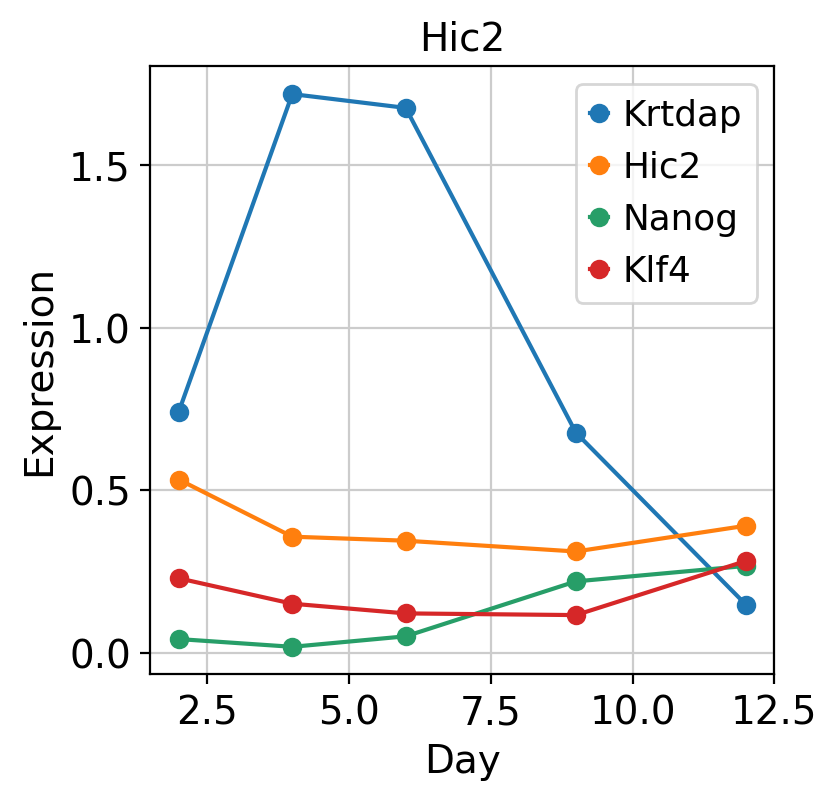

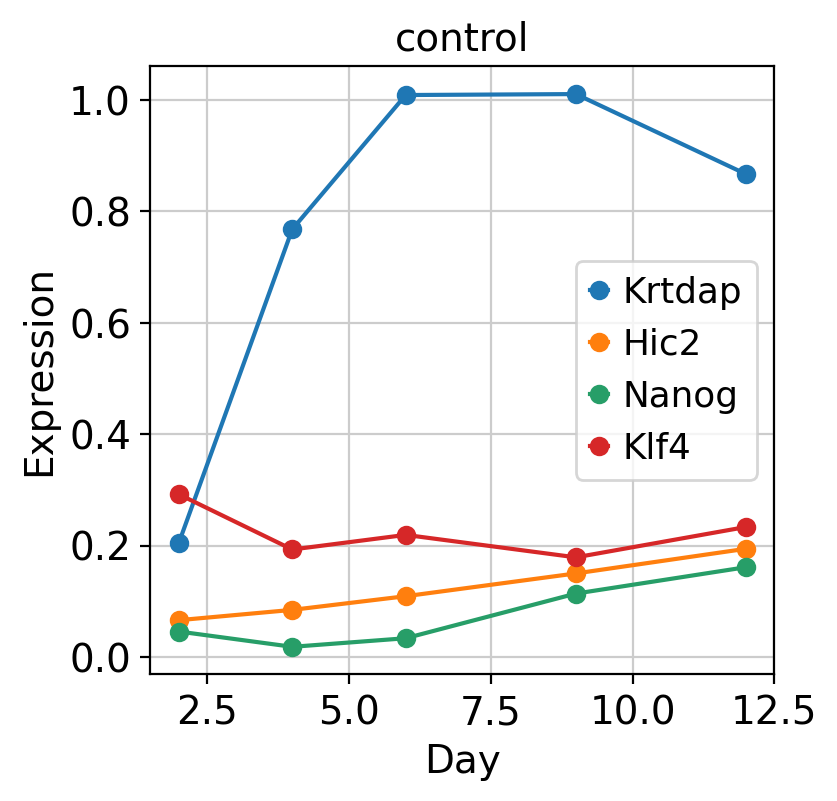

In [7]:
# %% Plot means

days = sorted(model_data.obs["exp_day"].dropna().unique())

for group in experiment_groups:
    figure, axis = pyplot.subplots()
    for gene in model_genes:
        gene_data = model_data[:, gene]
        means = [gene_data[(gene_data.obs["exp_day"] == day)*(gene_data.obs["group"] == group)].X.mean() for day in days]
        axis.plot(days, means, "o-", label=gene)
    axis.legend()
    axis.set_title(group)
    axis.set_xlabel("Day")
    axis.set_ylabel("Expression")

In [ ]:
# RNA velocity, needs splice counts

print(adata.obs_keys)
print(scvelo.pp.moments(adata))

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 13315 × 20959
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'Day', 'MEF.identity', 'Pluripotency', 'Proliferation', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'Senescence', 'Neural.identity', 'Trophoblast.identity', 'X.reactivation', 'XEN', 'Trophoblast.progenitors', 'Spiral.Artery.Trophpblast.Giant.Cells', 'Spongiotrophoblasts', 'Oligodendrocyte.precursor.cells..OPC.', 'Astrocytes', 'Cortical.Neurons', 'RadialGlia.Id3', 'RadialGlia.Gdf10', 'RadialGlia.Neurog2', 'Long.term.MEFs', 'Embryonic.mesenchyme', 'Cxcl12.co.expressed', 'Ifitm1.co.expressed', 'Matn4.co.expressed', '2c', 'keratinization', 'skin.development', 'muscle.structure.development', 'cartilage.development', 'blood.vessel.development', 'skeletal.system.development', 'nervous.system.development', 'neuron.development', 'stem.cell.population.maintenance', 'exp_day', 'group'
    var: 'vst.mean